### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2017/2018)

* The lab exercises should be made in groups of two or three people.
* The deadline is Friday, 01.06.
* Assignment should be submitted through BlackBoard! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [2]:
def binarize(X):
    return 1. * (X > 128)
    

In [3]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

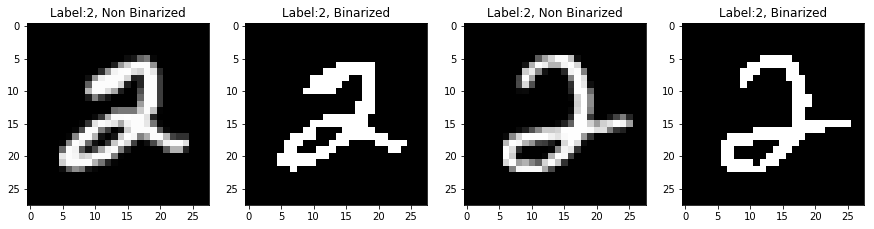

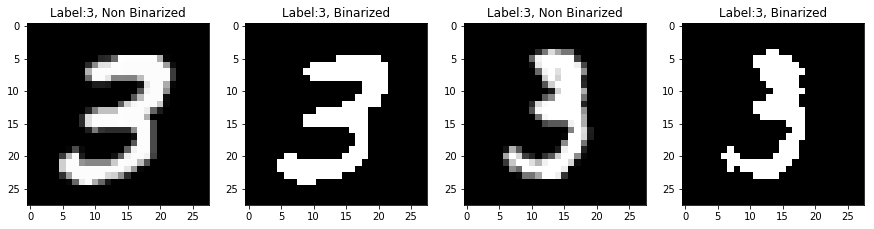

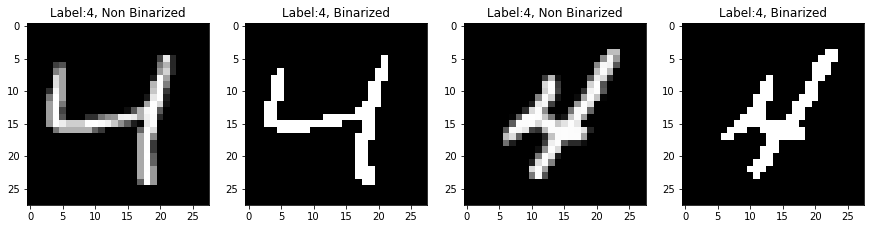

In [4]:
for digit in [2,3,4]:
    
    fig = plt.figure(figsize=(15,10))
    index = np.where(train_labels == digit)[0][:2]

    plt.subplot(141)
    plt.imshow(train_data[index[0]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[0]]) + ", Non Binarized")
    plt.subplot(142)
    plt.imshow(bin_train_data[index[0]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[0]])+ ", Binarized")
    plt.subplot(143)
    plt.imshow(train_data[index[1]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[1]]) + ", Non Binarized")
    plt.subplot(144)
    plt.imshow(bin_train_data[index[1]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[1]])+ ", Binarized")
    plt.show()

### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [5]:
def E_step(X, mu, pi):
    # YOUR CODE HERE
    N, D = shape(X)
    K = shape(pi)[0]
    
    gamma = np.zeros((N,K))
    for n in range(N):
        gamma_n = np.zeros(K)
        
        for k in range(K):
            p1_array = mu[k,:]**X[n,:]
            p0_array = (1-mu[k,:])**(1-X[n,:])
            p_array = p1_array * p0_array
            gamma_n[k] = pi[k]*np.prod(p_array)             
            
        normalizing_denom_n = np.sum(gamma_n)
        gamma_n /= normalizing_denom_n
#         print(np.sum(gamma_n)) # SHOULD BE 1
        
        gamma[n] = gamma_n
    
    return gamma

In [6]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [7]:
def M_step(X, gamma):
    # YOUR CODE HERE
    N, D = shape(X)
    K = shape(gamma)[1]
    
    Nk = np.sum(gamma, axis=0)
    pi = Nk/N
    mu = np.zeros((K, D))
    
    for k in range(K):
        mu[k] = (np.transpose(gamma[:,k]) @ X) / Nk[k]
    
    return mu, pi

In [8]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [9]:
def EM(X, K, max_iter, mu=None, pi=None):
    N, D = shape(X)
    convergence_value = 1e-5
    
    gamma = np.zeros((N, K))
    if mu is None:
        mu = np.random.uniform(low=.25, high=.75, size=(K, D))
    if pi is None:
        pi = np.ones(K) / K
    
    for i in range(1, max_iter):
        mu_prev, pi_prev = mu, pi
        
        gamma = E_step(X, mu, pi)
        mu, pi = M_step(X, gamma) 
        
        mu_update = np.linalg.norm(mu-mu_prev)
        pi_update = np.linalg.norm(pi-pi_prev)
        if i%10 == 0:
            print("Iteration ", i, "| delta_mu = %.7f" % mu_update, "| delta_pi = %.7f" % pi_update, "|")
            
        if mu_update < convergence_value and pi_update < convergence_value:
            print("Convergence reached at iteration ", i, ", early stopping!")
            return gamma, mu, pi        
        
    return gamma, mu, pi


Iteration  10 | delta_mu = 0.4628175 | delta_pi = 0.0099419 |
Iteration  20 | delta_mu = 0.1000866 | delta_pi = 0.0018891 |
Iteration  30 | delta_mu = 0.0222934 | delta_pi = 0.0006319 |
Iteration  40 | delta_mu = 0.0198851 | delta_pi = 0.0004066 |
Iteration  50 | delta_mu = 0.0237406 | delta_pi = 0.0003723 |
Iteration  60 | delta_mu = 0.0159691 | delta_pi = 0.0004339 |
Iteration  70 | delta_mu = 0.0030814 | delta_pi = 0.0000953 |
Iteration  80 | delta_mu = 0.0142458 | delta_pi = 0.0001409 |
Iteration  90 | delta_mu = 0.0040772 | delta_pi = 0.0000558 |


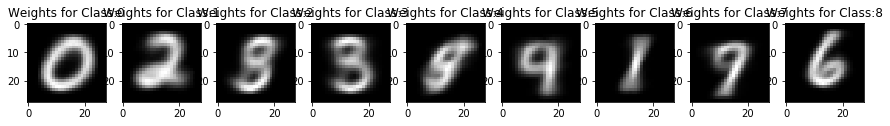

In [10]:
# TO BE REMOVED

gamma, mu, pi = EM(bin_train_data[:10000, :], 10, 100) #Subset

fig = plt.figure(figsize=(15,10))

for k in range(9):
    plt.subplot(191+k)
    plt.imshow(mu[k].reshape(28,28),cmap='gray') #Greys swaps colors
    plt.title("Weights for Class:"+str(k))

plt.show()

### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

Iteration  10 | delta_mu = 0.0091267 | delta_pi = 0.0006966 |
Iteration  20 | delta_mu = 0.0022320 | delta_pi = 0.0001330 |
Iteration  30 | delta_mu = 0.0010135 | delta_pi = 0.0000733 |
Iteration  40 | delta_mu = 0.0000200 | delta_pi = 0.0000018 |
Iteration  50 | delta_mu = 0.0001054 | delta_pi = 0.0000080 |
Iteration  60 | delta_mu = 0.0000329 | delta_pi = 0.0000019 |
Iteration  70 | delta_mu = 0.0000598 | delta_pi = 0.0000033 |
Iteration  80 | delta_mu = 0.0000851 | delta_pi = 0.0000055 |
Convergence reached at iteration  89 , early stopping!


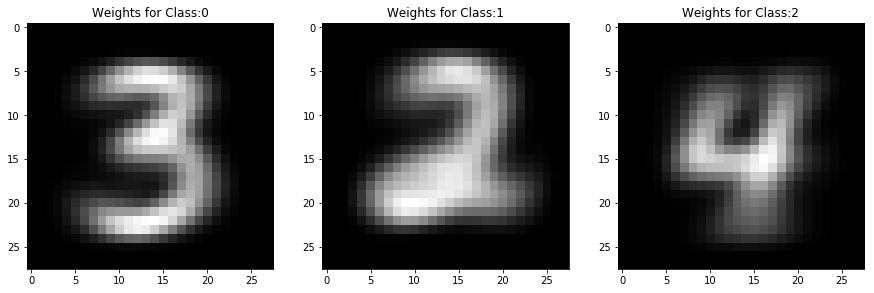

Mixture Coefficients (pi): [0.33148574 0.32031759 0.34819667]
Class-frequencies in the dataset:
2: 0.33227371591099214; 3: 0.34192181138809885; 4: 0.32580447270090906


In [126]:
# YOUR CODE HERE

mask = np.isin(train_labels, [2,3,4])
reduced_train_labels = train_labels[mask]
reduced_train_data = bin_train_data[mask]
# print(shape(reduced_train_data))

gamma3, mu3, pi3 = EM(reduced_train_data, 3, 100)

fig = plt.figure(figsize=(15,10))
for k in range(3):
    plt.subplot(131+k)
    plt.imshow(mu3[k].reshape(28,28),cmap='gray') #Greys swaps colors
    plt.title("Weights for Class:"+str(k))
plt.show()


from scipy.stats import itemfreq
frequencies = itemfreq(reduced_train_labels)[:, 1].flatten()

print('Mixture Coefficients (pi): {}'.format(pi3))
print('Class-frequencies in the dataset:')
print('; '.join(['{}: {}'.format(d, frequencies[i]/len(reduced_train_labels)) for i, d in enumerate([2, 3, 4])]))


Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

It is evident how different elements in latent space corresponds to the digits from different classes.
In the pictures above we show how, in different digits, the regions with active weight values correspond to the regions representing the shape of that particular digit.

The mixing coeffincients ($\pi$) follow roughly an uniform distribution over the 3 classes and resemble the distribution of the classes in the dataset

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

Iteration  10 | delta_mu = 0.0588632 | delta_pi = 0.0073930 |
Iteration  20 | delta_mu = 0.0367913 | delta_pi = 0.0042638 |
Iteration  30 | delta_mu = 0.0751544 | delta_pi = 0.0071101 |
Iteration  40 | delta_mu = 0.0141360 | delta_pi = 0.0011307 |
Iteration  50 | delta_mu = 0.0001886 | delta_pi = 0.0000244 |
Convergence reached at iteration  55 , early stopping!


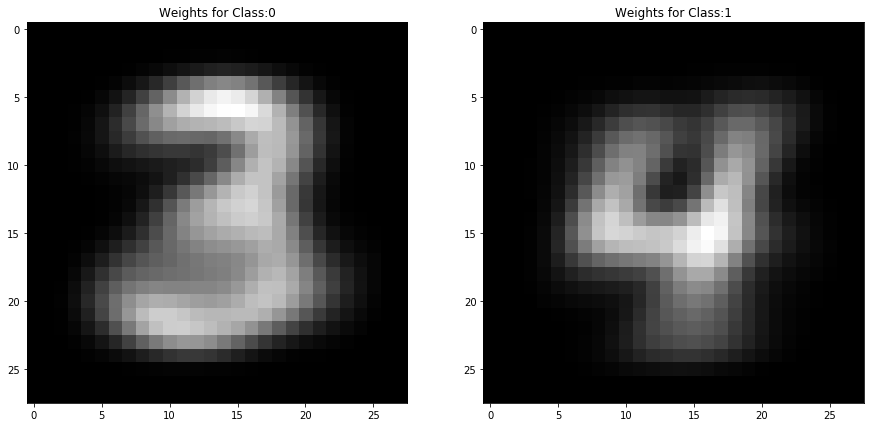

Iteration  10 | delta_mu = 0.3091310 | delta_pi = 0.0055583 |
Iteration  20 | delta_mu = 0.0505255 | delta_pi = 0.0005924 |
Iteration  30 | delta_mu = 0.0567463 | delta_pi = 0.0008245 |
Iteration  40 | delta_mu = 0.0221181 | delta_pi = 0.0003437 |
Iteration  50 | delta_mu = 0.0096525 | delta_pi = 0.0001614 |
Iteration  60 | delta_mu = 0.0062881 | delta_pi = 0.0001026 |
Iteration  70 | delta_mu = 0.0036901 | delta_pi = 0.0000557 |
Iteration  80 | delta_mu = 0.0077650 | delta_pi = 0.0001265 |
Iteration  90 | delta_mu = 0.0187423 | delta_pi = 0.0003186 |


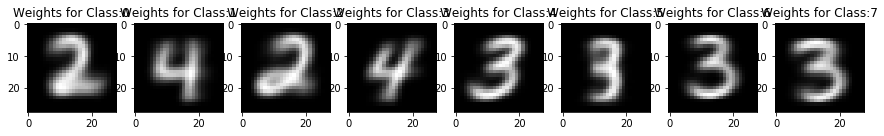

In [15]:
K = 2
_, mu2, _ = EM(reduced_train_data, K, 100)

fig = plt.figure(figsize=(15,10))
for k in range(K):
    plt.subplot(121+k)
    plt.imshow(mu2[k].reshape(28,28),cmap='gray') #Greys swaps colors
    plt.title("Weights for Class:"+str(k))
plt.show()

K = 8
_, mu8, _ = EM(reduced_train_data, K, 100)

fig2 = plt.figure(figsize=(15,10))
for k in range(K):
    plt.subplot(181+k)
    plt.imshow(mu8[k].reshape(28,28),cmap='gray') #Greys swaps colors
    plt.title("Weights for Class:"+str(k))
plt.show()

When the number of latent classes K is lower than the true classes, some of the classes (the most similar ones) appear to be clustered together. For example, using K=2 for classes [2,3,4], the spaces for digits 2 and 3 (more similar) are merged together and result in some blurry weight matrix.

On the other way, when more latent classes are present with respect to the number of true classes, the spaces will represent digits from the same classes with different shapes. Namely, subcluster in the larger cluster corresponding to a digit are created and represented with different weights

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

11047 misclassified images out of 17931


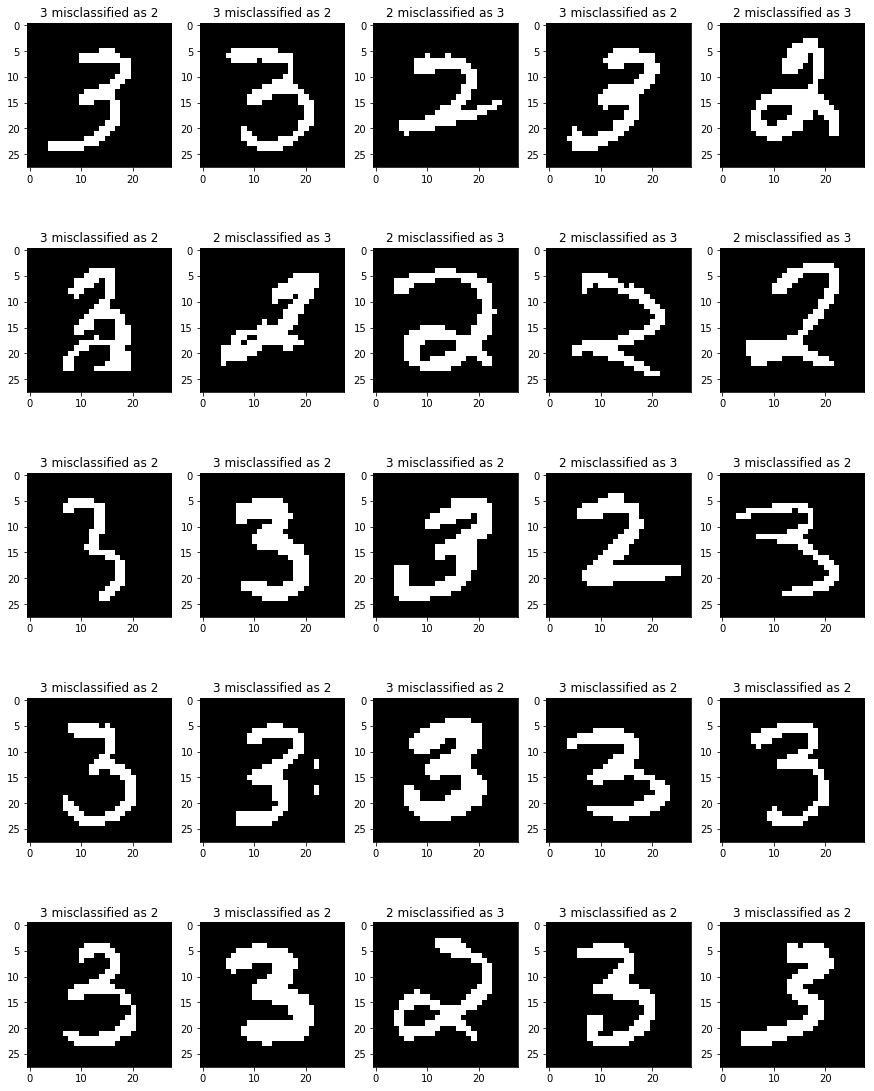

In [132]:
from collections import defaultdict


def test_classification(data, labels, classes, assigned_classes, gamma):

    predictions = np.zeros(len(data), dtype=int)


    for i in range(len(data)):
        predictions[i] = assigned_classes[np.argmax(gamma[i, :])]



    misclassified_indexes = predictions != labels    
    number_of_errors = sum(misclassified_indexes)    

    print('{} misclassified images out of {}'.format(number_of_errors, len(data)))    


    sampled_indexes = np.where(misclassified_indexes)[0]
    np.random.shuffle(sampled_indexes)


    rows = 5
    columns = 5

    sampled_indexes = sampled_indexes[:rows*columns]

    fig, axes = plt.subplots(rows, columns, figsize=(15, rows*4))

    for i in range(len(sampled_indexes)):

        ax = axes[i//columns, i % columns]

        ax.imshow(data[sampled_indexes[i]].reshape(28,28),cmap='gray') #Greys swaps colors
        ax.set_title("{} misclassified as {}".format(labels[sampled_indexes[i]], predictions[sampled_indexes[i]]))

    plt.show()
    
    

classes = [2, 3, 4]

scores = [defaultdict(float) for i in range(len(classes))]

for x, l in zip(reduced_train_data, reduced_train_labels):
    for k in range(len(classes)):
        #log_prob = sum(np.log(mu[k][x == 1])) + sum(np.log(1 - mu[k][x != 1]))
        #scores[k][l] += log_prob
        scores[k][l] += -sum((mu[k] - x)**2)


scores = [dict(scores[i]) for i in range(len(classes))]

assigned_classes = [max(scores[i], key=scores[i].get) for i in range(len(classes))]

#     print(scores)
#     print(assigned_classes)

test_classification(reduced_train_data, reduced_train_labels, classes, assigned_classes, gamma3)    


YOUR ANSWER HERE

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

Iteration  10 | delta_mu = 0.0006934 | delta_pi = 0.0000136 |
Iteration  20 | delta_mu = 0.0000062 | delta_pi = 0.0000004 |
Convergence reached at iteration  20 , early stopping!
1596 misclassified images out of 17931


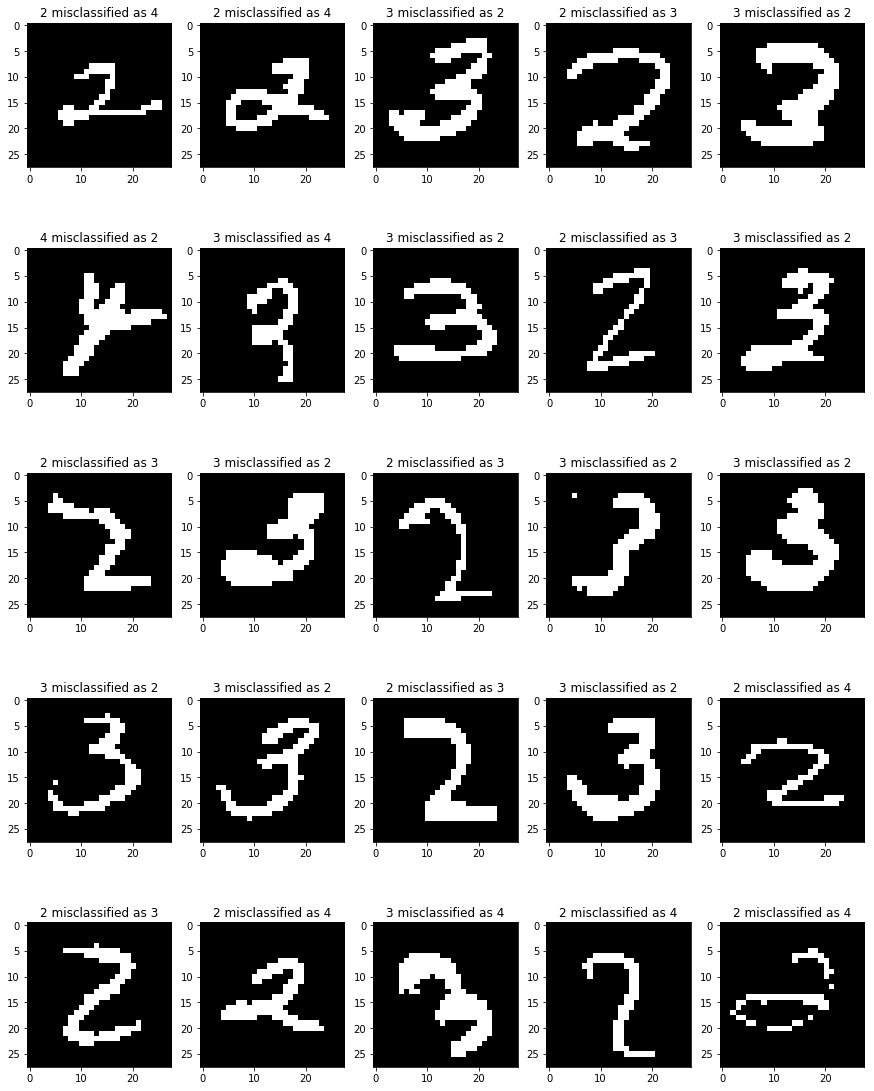

In [133]:

frequencies = itemfreq(reduced_train_labels)
pi = frequencies[:, 1].astype(float) / len(reduced_train_labels)

K = len(classes)
mu = np.zeros((K, 28*28))

classes_map = {}
for i, c in enumerate(classes):
    classes_map[c] = i

classes_count = np.zeros(K)
    
for x, l in zip(reduced_train_data, reduced_train_labels):
    mu[classes_map[l], :] += x
    classes_count[classes_map[l]] += 1

mu = mu / classes_count.reshape(-1, 1)

gamma_i, mu_i, pi_i = EM(reduced_train_data, K, 100, mu=mu, pi=pi)

test_classification(reduced_train_data, reduced_train_labels, classes, classes, gamma_i)


YOUR ANSWER HERE

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [110]:
def log_bernoulli_loss(x_hat, x):
    
#     loss = -x * torch.log(x_hat) - (1 - x)*torch.log(1 - x_hat)
    
#     loss = loss.sum() #loss.sum(2) ??
    
    loss = F.binary_cross_entropy(x_hat, x, size_average=False)

    
    return loss


In [111]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!

YOUR ANSWER HERE

$\mathcal{KL}(q || p) = -\frac{1}{2} D \ln \sigma^2 + \frac{1}{2} \mu^T\mu -\frac{1}{2} D + \frac{1}{2} D \sigma^2$

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

# IT DOES NOT MAKE SENSE... logvar SHOULD JUST BE A SCALAR BUT IT IS A VECTOR

In [112]:
def KL_loss(mu, logvar):
#     N, D = mu.size()
#     norm = mu.pow(2)
#     loss = N*(-0.5*D) -0.5*torch.sum(logvar) + 0.5*torch.sum(norm) + 0.5*torch.sum(torch.exp(logvar))
    
    loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return loss


In [113]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [114]:
def loss_function(x_hat, x, mu, logvar):
    return log_bernoulli_loss(x_hat, x) + KL_loss(mu, logvar)


In [115]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [116]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [117]:
def encode(self, x):
    
    e = self.fc1(x)
    e = F.relu(e)
    
    mu = self.fc21(e)
#     mu = F.tanh(mu)
    
    logvar = self.fc22(e)
#     logvar = F.relu(logvar)
    
    return mu, logvar


In [118]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [119]:
def reparameterize(self, mu, logvar):
    
    z = mu + torch.exp(0.5*logvar)*torch.randn_like(mu)
    
    return z


In [120]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [121]:
def decode(self, z):
    
    y = self.fc3(z)
    y = F.relu(y)
    
    y = self.fc4(y)
    
    x_hat = F.sigmoid(y)
    
    return x_hat


In [122]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [123]:
def forward(self, x):
    x = x.view(-1, 784)
    
    mu, logvar = self.encode(x)
    
    z = self.reparameterize(mu, logvar)
    
    x_hat = self.decode(z)
    
    return x_hat, mu, logvar


In [124]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [125]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [126]:
# Hyperparameters
# fc1_dims = (?,?)
# fc21_dims =
# fc22_dims =
# fc3_dims =
# fc4_dims =
# lr =
# batch_size =
# epochs =

hidden_layer_size = 400
latent_space_size = 20

fc1_dims = (28*28, hidden_layer_size)
fc21_dims = (hidden_layer_size, latent_space_size)
fc22_dims = (hidden_layer_size, latent_space_size)
fc3_dims = (latent_space_size, hidden_layer_size)
fc4_dims = (hidden_layer_size, 28*28)
lr = 0.001
batch_size = 128
epochs = 10



In [127]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [128]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 548.218994
Train Epoch: 1 [12800/60000 (21%)]	Loss: 179.038406
Train Epoch: 1 [25600/60000 (43%)]	Loss: 154.299728
Train Epoch: 1 [38400/60000 (64%)]	Loss: 136.146194
Train Epoch: 1 [51200/60000 (85%)]	Loss: 137.696609
====> Epoch: 1 Average loss: 163.9566
Train Epoch: 2 [0/60000 (0%)]	Loss: 128.446014
Train Epoch: 2 [12800/60000 (21%)]	Loss: 118.466515
Train Epoch: 2 [25600/60000 (43%)]	Loss: 121.666725
Train Epoch: 2 [38400/60000 (64%)]	Loss: 118.164062
Train Epoch: 2 [51200/60000 (85%)]	Loss: 118.403358
====> Epoch: 2 Average loss: 121.3418
Train Epoch: 3 [0/60000 (0%)]	Loss: 115.683067
Train Epoch: 3 [12800/60000 (21%)]	Loss: 115.601486
Train Epoch: 3 [25600/60000 (43%)]	Loss: 116.874527
Train Epoch: 3 [38400/60000 (64%)]	Loss: 116.663383
Train Epoch: 3 [51200/60000 (85%)]	Loss: 113.716934
====> Epoch: 3 Average loss: 114.6640
Train Epoch: 4 [0/60000 (0%)]	Loss: 109.423950
Train Epoch: 4 [12800/60000 (21%)]	Loss: 114.831970
Train Epoch: 4 [25600/

Run the box below to check if the model you trained above is able to correctly reconstruct images.

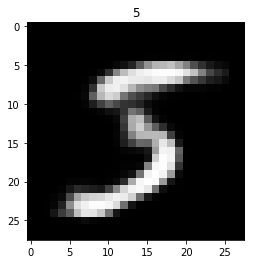

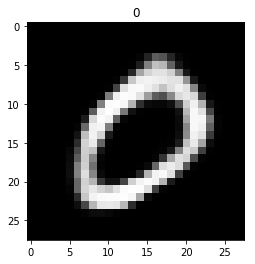

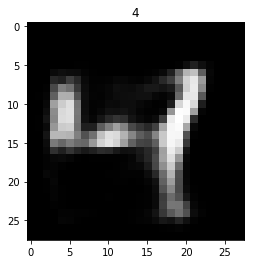

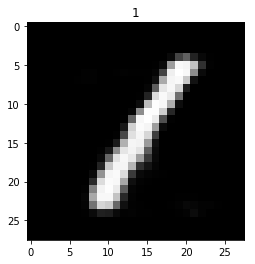

In [129]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

Train Epoch: 1 [0/60000 (0%)]	Loss: 556.354858
Train Epoch: 1 [12800/60000 (21%)]	Loss: 191.782272
Train Epoch: 1 [25600/60000 (43%)]	Loss: 187.562439
Train Epoch: 1 [38400/60000 (64%)]	Loss: 171.920456
Train Epoch: 1 [51200/60000 (85%)]	Loss: 170.257584
====> Epoch: 1 Average loss: 189.7763
Train Epoch: 2 [0/60000 (0%)]	Loss: 166.193787
Train Epoch: 2 [12800/60000 (21%)]	Loss: 167.885071
Train Epoch: 2 [25600/60000 (43%)]	Loss: 161.370865
Train Epoch: 2 [38400/60000 (64%)]	Loss: 166.489166
Train Epoch: 2 [51200/60000 (85%)]	Loss: 158.093262
====> Epoch: 2 Average loss: 165.8276
Train Epoch: 3 [0/60000 (0%)]	Loss: 160.789810
Train Epoch: 3 [12800/60000 (21%)]	Loss: 160.252365
Train Epoch: 3 [25600/60000 (43%)]	Loss: 159.205002
Train Epoch: 3 [38400/60000 (64%)]	Loss: 161.420517
Train Epoch: 3 [51200/60000 (85%)]	Loss: 161.646622
====> Epoch: 3 Average loss: 162.0872
Train Epoch: 4 [0/60000 (0%)]	Loss: 163.585297
Train Epoch: 4 [12800/60000 (21%)]	Loss: 167.602798
Train Epoch: 4 [25600/

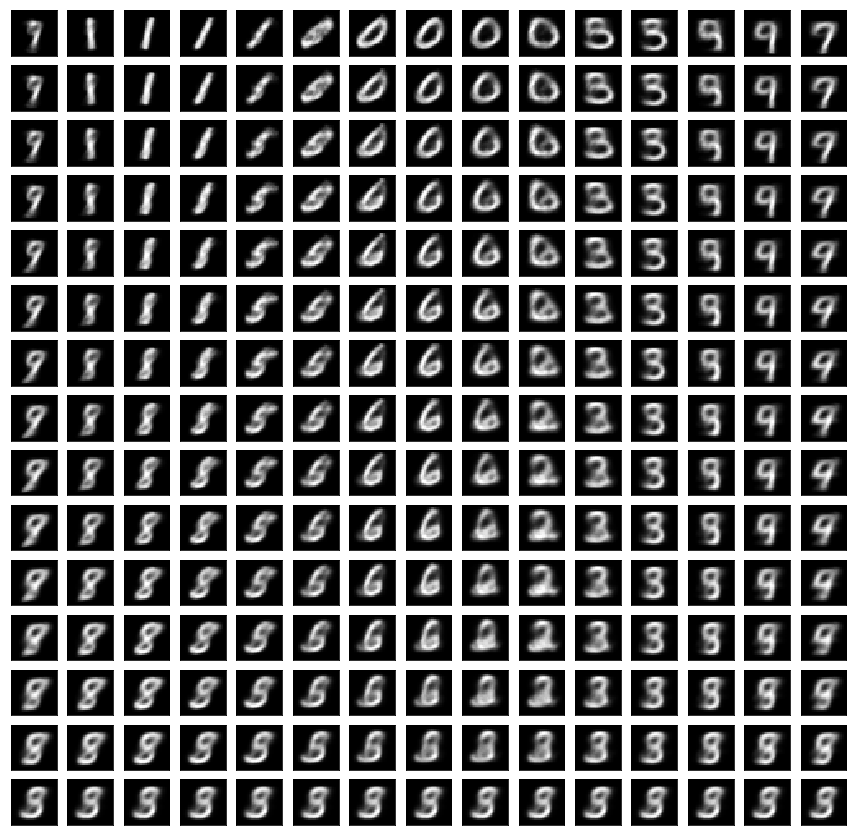

In [139]:
hidden_layer_size = 400
latent_space_size = 2

fc1_dims = (28*28, hidden_layer_size)
fc21_dims = (hidden_layer_size, latent_space_size)
fc22_dims = (hidden_layer_size, latent_space_size)
fc3_dims = (latent_space_size, hidden_layer_size)
fc4_dims = (hidden_layer_size, 28*28)
lr = 0.001
batch_size = 64
epochs = 10

# Init model
VAE_MNIST_2 = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer_2 = optim.Adam(VAE_MNIST_2.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST_2, optimizer_2)


def box_muller(u1, u2):
    R = np.sqrt(-2*np.log(u1))
    theta = 2*np.pi*u2
    
    z1 = R*np.cos(theta)
    z2 = R*np.sin(theta)
    return z1, z2


N = 15


fig, axes = plt.subplots(N, N, figsize=(N, N))

for i, u1 in enumerate(np.linspace(0.1, 1, N)):
    for j, u2 in enumerate(np.linspace(0.1, 1, N)):
        
        z1, z2 = box_muller(u1, u2)
        
        rec = VAE_MNIST_2.decode(torch.FloatTensor([z1, z2]).view(1, 2))

        ax = axes[i, j]
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(rec.view(28,28).squeeze().data.numpy(),cmap='gray') #Greys swaps colors

plt.show()

        
    

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


In Amortized Inference, instead of using a different set of parameters for each datapoint as in Mean-Field Inference, part of the parameters are shared between the datapoints.

In Part2, it is used in the decoder: while the mean and the variances are parameters of a particular datapoint, the parameters of the decoder network are the same for any datapoint.

The main benefit is a smaller set of parameters to learn, reducing the cost of the algorithm.